# INPUT: 4-col tsv readable text from 4-col tsv full content file
* The input should be a tsv table with "", neo_search_transaction_id, variable, value

# Take two visible text files and create map of xy word cross counts
* Open both files and gather all words in two separate lists.
* Create a dictionary of tuples containing counts for each word ex: "word":(x times in file 1, y times in file 2)

In [4]:
! ls data/
import pandas as pd
view = pd.read_csv('data/yes_matches.tsv', delimiter='\t')
view.head()

combined_matches.tsv no_matches.tsv       yes_matches.tsv


,Unnamed: 0,neo_search_transaction_id,variable,value
0,0,72994,names,"[{""names"": ""Seven's""}, {""names"": ""Seven's Medi..."
1,1,72995,names,"[{""names"": ""Spoonfed NYC Country""}]"
2,2,72996,names,"[{""names"": ""Mr K's CLOSED""}, {""names"": ""New Yo..."
3,3,72997,names,"[{""names"": ""Palermo""}, {""names"": ""PALERMO EXPR..."
4,4,72998,names,"[{""names"": ""Palermo Ristorante""}, {""names"": ""P..."


In [61]:
# input two files with visible text per line and output a dictionary with x,y coordinates for words
target    = "data/yes_matches.tsv"
reference = "data/combined_matches.tsv"
import re
from collections import defaultdict

def reformat_words(line_words):
    line_words = line_words.lower()
    # HACK because later on we trip on " when we try to generate arrays
    line_words = line_words.replace('"', '')
    return [word for word in re.split(r'(\W)', line_words) if (not len(word.strip()) == 0) and (word.strip().isalpha())]


def file_len(fname):
    with open(fname) as f:
        for i, l in enumerate(f):
            pass
    return i + 1

debug = False
# Helper function to extract all text from a single file
def get_dict_word_pairs(source_file1, source_file2):
    len_f1 = file_len(source_file1)
    len_f2 = file_len(source_file2)
    ratio = float(len_f1)/float(len_f2)
    print("Lengths, TARGET: {}\tREFERENCE: {}\tRATIO: {}".format(len_f1, len_f2, ratio))
    
    word_dict = {}
    column_with_text = 3
    
    times_going = 0
    for idx, source_file in enumerate([source_file1, source_file2]):
        with open(source_file, 'r') as source:
            
            for line in source:
                full_text = line.split('\t')[column_with_text]
                words = reformat_words(full_text)
                if debug:
                    print idx, words
                
                for idx_word, word in enumerate(words):
                    if word == 'going':
                        times_going += 1
                        print("got one more for {}: {}".format(idx, times_going))
                    try:
                        word_dict[word][idx] += 1
                    except:
                        word_dict[word] = [0,0]
                        word_dict[word][idx] += 1
                    if idx_word+1 < len(words):
                        try:
                            word_dict["{} {}".format(words[idx_word], words[idx_word + 1])][idx] += 1
                        except:
                            word_dict["{} {}".format(words[idx_word], words[idx_word + 1])] = [0,0]
                            word_dict["{} {}".format(words[idx_word], words[idx_word + 1])][idx] += 1
                    if idx_word+2 < len(words):
                        try:
                            word_dict["{} {} {}".format(words[idx_word], words[idx_word + 1],words[idx_word + 2])][idx] += 1
                        except:
                            word_dict["{} {} {}".format(words[idx_word], words[idx_word + 1],words[idx_word + 2])] = [0,0]
                            word_dict["{} {} {}".format(words[idx_word], words[idx_word + 1],words[idx_word + 2])][idx] += 1
    
    # Assuming you always have MORE in the ref context file, normalize the numbers (scale  y)
    for key, val in word_dict.iteritems():
        word_dict[key] = [val[0], int(ratio*val[1])]
    return word_dict


word_dict = get_dict_word_pairs(target, reference)
print "DONE, FOUND THIS MANY WORDS COUNTS:", len(word_dict)        

Lengths, TARGET: 379	REFERENCE: 776	RATIO: 0.488402061856
got one more for 0: 1
got one more for 0: 2
got one more for 0: 3
got one more for 0: 4
got one more for 0: 5
got one more for 0: 6
got one more for 0: 7
got one more for 0: 8
got one more for 0: 9
got one more for 0: 10
got one more for 0: 11
got one more for 0: 12
got one more for 0: 13
got one more for 0: 14
got one more for 0: 15
got one more for 0: 16
got one more for 0: 17
got one more for 0: 18
got one more for 0: 19
got one more for 0: 20
got one more for 0: 21
got one more for 0: 22
got one more for 0: 23
got one more for 0: 24
got one more for 0: 25
got one more for 0: 26
got one more for 0: 27
got one more for 0: 28
got one more for 0: 29
got one more for 0: 30
got one more for 0: 31
got one more for 0: 32
got one more for 0: 33
got one more for 0: 34
got one more for 0: 35
got one more for 0: 36
got one more for 0: 37
got one more for 0: 38
got one more for 0: 39
got one more for 0: 40
got one more for 0: 41
got one 

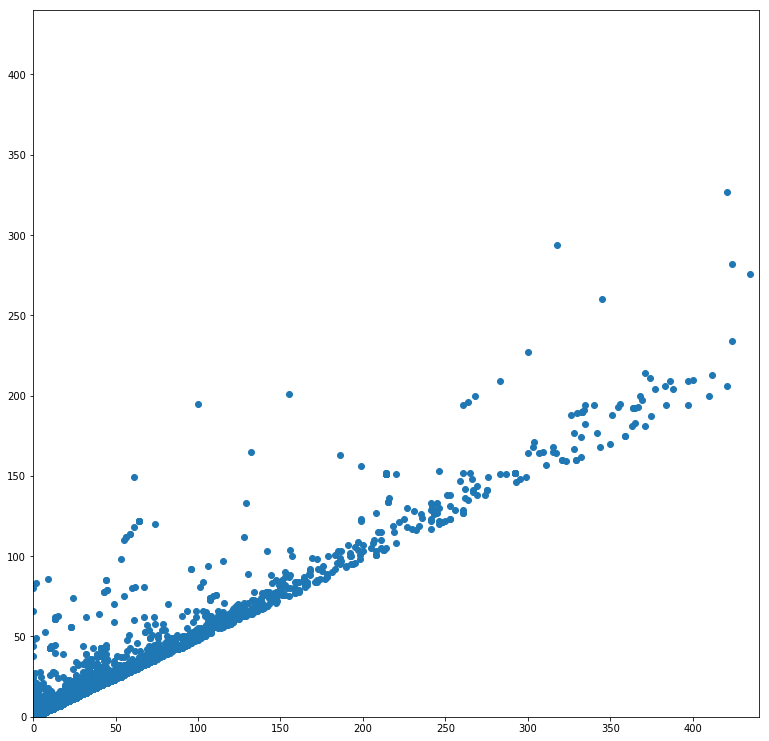

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

xarr = []
yarr = []
for word, xy_pair in word_dict.iteritems():
    xarr.append(xy_pair[0])
    yarr.append(xy_pair[1])
    

plt.figure(figsize = (13,13))
size = 440
plt.axis([0,size,0,size])
plt.scatter(xarr,yarr)
plt.show()

In [57]:
# sort through the dictionary and pull out the words closes to the axis of language we want
import math

def get_top_hits(word_dict, topn=20000, xmin=0, cut_angle=40, xmax=6000000, ymin=0, ymax=100099):
    final_list = []
    for word, xy in word_dict.iteritems():
        if xy[0] <= xmax and xy[0] >= xmin and xy[1] <= ymax and xy[1] >= ymin:
            if float(xy[1])/float(xy[0]+1) < math.tan(math.radians(cut_angle)):
                #print word, xy[0], xy[1], "\t",float(xy[1])/float(xy[0]+1), math.tan(math.radians(cut_angle))
                final_list.append( (word, xy))
    
    final_list.sort(key=lambda x: x[1][0])
    final_list.reverse()
    return final_list[:topn]

def stringify_list(lhits):
    ret_strings = []
    for hit in lhits:
        #ret_strings.append("\"(\\W {}|{} \\W)\"".format(hit[0], hit[0]))
        ret_strings.append("\" {} \"".format(hit[0]))
    return ','.join(ret_strings)
    
        
final_list = get_top_hits(word_dict, 2000)
#print stringify_list(final_list)
if True:
    for item in final_list:
        print item

('the', [6764, 3656])
('and', [5675, 3096])
('source', [4445, 2361])
('text', [4442, 2359])
('a', [4420, 2380])
('title', [4176, 2176])
('date', [3994, 2092])
('com', [3817, 2353])
('categories', [3565, 2157])
('description', [3440, 1765])
('media', [3406, 1722])
('https', [3058, 1835])
('with', [2946, 1577])
('foursquare', [2914, 1585])
('price', [2903, 1430])
('date text', [2876, 1503])
('tripadvisor', [2621, 1325])
('upvotes downvotes', [2603, 1375])
('downvotes', [2603, 1375])
('upvotes', [2603, 1375])
('foursquare upvotes downvotes', [2603, 1375])
('foursquare upvotes', [2603, 1375])
('source foursquare upvotes', [2603, 1375])
('source foursquare', [2603, 1375])
('to', [2494, 1376])
('of', [2448, 1400])
('prices', [2367, 1159])
('prices price', [2234, 1091])
('is', [2172, 1179])
('price description', [2123, 1036])
('for', [2105, 1132])
('images', [2101, 1175])
('in', [2100, 1181])
('rating', [2019, 1099])
('images https', [2009, 1088])
('s', [1958, 1033])
('jpg', [1952, 1045])
('i

In [17]:
# Final cell, choose a reference language, and get list of keywords against that for the others.
groups = [
    "yes",
    "no"
]
# source of interest should be source_2, which ends up on x axis <->
REF_GROUP = "combined"


path_ref_group = "data/{}_matches.tsv".format(REF_GROUP)

for group in groups:
    path_group = "data/{}_matches.tsv".format(group)
    word_dict = get_dict_word_pairs(path_group, path_ref_group)
    final_list = get_top_hits(word_dict, 200)
    length_list = len(final_list)
    print "    [\n        \"--{} {}--\", {},\n    ],".format(group, length_list, stringify_list(final_list))


Lengths, TARGET: 379	REFERENCE: 776	RATIO: 0.488402061856
    [
        "--yes 200--", " date : false "," Linguini "," 5 , Value "," false , text "," Served with choice "," . The service "," : 16 . "," Oz . "," Tavern "," text : null "," . Food "," price : 16 "," Good for a "," bar , "," Cup "," null , quote "," of side } "," Happy Hour "," the restaurant "," answer "," and - "," a few "," ambiance "," Pan "," value : 5 "," Shrimp & "," was good "," portions "," Cal } , "," l / 05 "," side } , "," 9 . 95 "," Hand - "," . ] "," . Good "," : 23 "," P "," a Date "," Served with rice "," lettuce , "," waitress "," . ] } "," for a Date "," We had "," waiter "," , shrimp "," , avocado , "," Grill "," 14 . 95 "," sum "," back . "," bars "," 4 , service "," extra "," categories : Bars "," - 10 - "," dirty rice } "," - 08 - "," to eat "," . But "," breakfast "," 08 - "," & Cheese "," chinese "," Sausage "," pork "," l / 10 "," l / 0e "," appetizer "," was not "," , 2005 "," Saturday "," Baked "